In [20]:
%load_ext autoreload
%autoreload 2

# Head

imports

In [126]:
import src.paths
from src.csd import wavelet_transform, resample_1250_250_Hz

params

In [280]:
ANIMAL = 'M023'
DATE = '2022-09-16'
EPOCH = 0
CHANNEL = 39
FREQ_MIN = 4
FREQ_MAX = 80
FREQ_BINS = 40
PHASE_BINS = 20
LOG_FREQS = True

load and trim

In [173]:
FRAME_1250 = 1 / 1250
FRAME_250 = 1 / 250
START = (30 * EPOCH + 5) * 60
END = (30 * EPOCH + 25) * 60

In [174]:
%%time
csd = pd.read_pickle(src.paths.DATA / DATE / f'{DATE}-hpc-csd.pkl')
csd = csd.loc[START:END - FRAME_1250, CHANNEL]

spk = pd.read_pickle(src.paths.DATA / DATE / f'{DATE}-hpc-spikes.pkl')
spk = spk.loc[START:END - FRAME_250]

units = spk.columns.to_frame()
spk.columns = units.unit

CPU times: user 72 ms, sys: 5.46 s, total: 5.53 s
Wall time: 7.39 s


# Body

compute wavelet transform, downsample, compute instantaneous phase and amplitude

In [175]:
%%time
hilb = wavelet_transform(csd, freq_min=FREQ_MIN, freq_max=FREQ_MAX, freq_bins=FREQ_BINS, log=LOG_FREQS)
hilb = resample_1250_250_Hz(hilb)

CPU times: user 34 s, sys: 581 ms, total: 34.5 s
Wall time: 34.5 s


In [186]:
amp = np.abs(hilb.values)
amp = pd.DataFrame(amp, index=hilb.index, columns=hilb.columns)
phase = np.angle(hilb.values)
phase = pd.DataFrame(phase, index=hilb.index, columns=hilb.columns)

quantify when spikes occured relative to phase

In [187]:
UNIT = 302

In [200]:
spk_amp = amp[spk[UNIT].astype('bool')]
spk_phase = phase[spk[UNIT].astype('bool')]

In [201]:
FREQ = phase.columns[10]

In [243]:
bins = np.linspace(-np.pi, np.pi, PHASE_BINS + 1)

In [281]:
idx = pd.Series(bins[:-1], name='phase')
hist = pd.DataFrame(index=idx, columns=phase.columns)
for FREQ in phase.columns:
    count, _ = np.histogram(spk_phase[FREQ], bins)
    hist[FREQ] = count

# Tail

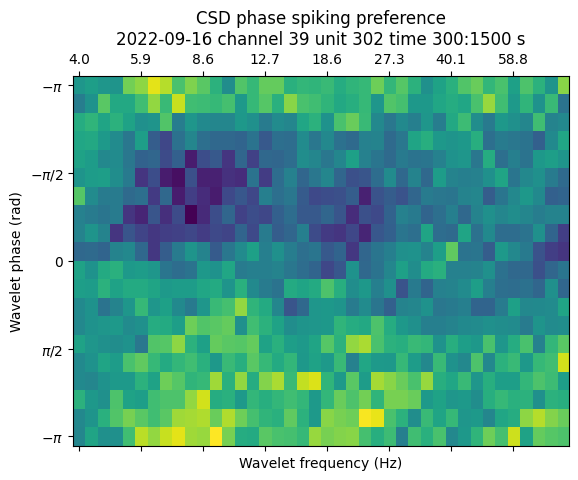

In [284]:
plt.figure()
plt.gca().matshow(hist.values, interpolation='none')
plt.axis('auto')
plt.xticks(np.arange(hist.shape[1])[::5], np.round(hist.columns, 1)[::5])
plt.yticks(np.arange(5) / 4 * (hist.shape[0] - 1), ['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$-\pi$'])
plt.xlabel('Wavelet frequency (Hz)')
plt.ylabel('Wavelet phase (rad)')
plt.title(f'CSD phase spiking preference\n{DATE} channel {CHANNEL} unit {UNIT} time {START}:{END} s')
plt.savefig(f'{DATE}-phase-spike-hist-channel-{CHANNEL}-unit-{UNIT}-time-{START}-{END}', dpi=300)
plt.show()